<a href="https://colab.research.google.com/github/deeplearningexplore/siamese/blob/main/question_pairs_detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c quora-question-pairs

Saving kaggle.json to kaggle.json
 96% 109M/114M [00:01<00:00, 85.3MB/s] 
100% 114M/114M [00:01<00:00, 94.5MB/s]
 24% 5.00M/21.2M [00:00<00:01, 10.5MB/s]
100% 21.2M/21.2M [00:00<00:00, 36.0MB/s]
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
100% 4.95M/4.95M [00:00<00:00, 51.4MB/s]



In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import pandas as pd
import tensorflow.keras.backend as K
import tqdm


%matplotlib inline

In [3]:
zip = zipfile.ZipFile("test.csv.zip", "r")
zip.extractall("./data")


In [4]:
zip = zipfile.ZipFile("train.csv.zip", "r")
zip.extractall("./data")

zip.close()

In [5]:
!rm "train.csv.zip"
!rm "test.csv.zip"

In [6]:
train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")
print(train_data.head())
print(test_data.head())

   id  qid1  ...                                          question2 is_duplicate
0   0     1  ...  What is the step by step guide to invest in sh...            0
1   1     3  ...  What would happen if the Indian government sto...            0
2   2     5  ...  How can Internet speed be increased by hacking...            0
3   3     7  ...  Find the remainder when [math]23^{24}[/math] i...            0
4   4     9  ...            Which fish would survive in salt water?            0

[5 rows x 6 columns]
   test_id  ...                                          question2
0        0  ...  Why did Microsoft choose core m3 and not core ...
1        1  ...        How much cost does hair transplant require?
2        2  ...                      What you send money to China?
3        3  ...                                  What foods fibre?
4        4  ...                     How their can I start reading?

[5 rows x 3 columns]


In [7]:
train_data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [8]:
train_data = train_data[train_data["is_duplicate"]==1]
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


In [9]:
train_d1 = train_data['question1'].values
train_d2 = train_data['question2'].values

In [10]:
train_d1.shape

(149263,)

In [11]:
train_d = np.concatenate([train_d1,train_d2])

In [12]:
train_d.shape

(298526,)

In [13]:
oov_token = "<ukw>"
pad = "post"


In [14]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(train_d)
word_index = tokenizer.word_index


In [15]:
len(word_index)

31468

In [16]:
train_data1 = tokenizer.texts_to_sequences(train_d1)

In [17]:
train_data2 = tokenizer.texts_to_sequences(train_d2)

In [18]:
word_index["ambulance"]

19614

In [19]:
def data_generator(q1,q2,batch_size,num_units):
  indexes = list(range(len(q1)))
  indexes = tf.random.shuffle(indexes)
  length = len(q1)
  input1 = []
  input2 = []
  index = 0

  while True:
    if index==length:
      index = 0
      indexes = tf.random.shuffle(indexes)
    
    input1.append(q1[indexes[index]])
    input2.append(q2[indexes[index]])

    index+=1

    if len(input1)==batch_size:
      max_length = np.max((np.max([len(x) for x in input1]),np.max([len(x) for x in input2])))
      max_length = 2**int(np.ceil(np.log2(max_length)))

      input1 = tf.keras.preprocessing.sequence.pad_sequences(input1,maxlen=max_length,padding=pad,truncating=pad)
      input2 = tf.keras.preprocessing.sequence.pad_sequences(input2,maxlen=max_length,padding=pad,truncating=pad)

      yield [np.array(input1),np.array(input2)],np.zeros((2,batch_size, num_units))

      input1 = []
      input2 = []



In [70]:
vocab_size =  len(tokenizer.word_index) + 1
dimensions = 300
batch_size = 128
num_units = 1024

In [21]:
a,b=next(data_generator(train_data1,train_data2,5,num_units))

In [22]:
print(a[0].shape)
p = np.array(a)
print(p)
print(b)

(5, 16)
[[[   5   31    6   83   19  920   73    0    0    0    0    0    0    0
      0    0]
  [   3   11   26 1932  838  364   45  747  427  214    0    0    0    0
      0    0]
  [   3    4   24 3911  599    0    0    0    0    0    0    0    0    0
      0    0]
  [  74   21   53    7   34 5418    0    0    0    0    0    0    0    0
      0    0]
  [   3   25 4621 1358   18    0    0    0    0    0    0    0    0    0
      0    0]]

 [[   5   13    6 1871    7   83   19   73    0    0    0    0    0    0
      0    0]
  [   3   11   26 1428  163   45  427  214    0    0    0    0    0    0
      0    0]
  [   3   11    2 3911  966   12   15    0    0    0    0    0    0    0
      0    0]
  [   3   25   21  145    7   34 5418    0    0    0    0    0    0    0
      0    0]
  [   3    4 4621   14    3   64   21 3798    7 2790    0    0    0    0
      0    0]]]
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ..

In [23]:
!wget "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"

--2020-10-15 12:59:56--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  79.5MB/s    in 9.9s    

2020-10-15 13:00:06 (65.4 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [24]:
zip = zipfile.ZipFile("wiki-news-300d-1M.vec.zip", "r")
zip.extractall("./data")
zip.close()

In [25]:
!rm "wiki-news-300d-1M.vec.zip"

In [26]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.asarray(tokens[1:], dtype='float32')
    return data

embedding_vectors =  load_vectors("data/wiki-news-300d-1M.vec")

In [27]:
len(embedding_vectors)

999994

In [28]:
embedding_matrix = np.zeros((vocab_size, dimensions))
for word,index in word_index.items():
  val = embedding_vectors.get(word, None)
  if val is not None:
    embedding_matrix[index] = val

In [29]:
del embedding_vectors

In [30]:
# tf.compat.v1.enable_eager_execution()

In [71]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            dimensions,
                                            weights=[embedding_matrix],
                                            trainable = False
                                            )

model = tf.keras.Sequential()
model.add(embedding_layer)
model.add(tf.keras.layers.LSTM(num_units))

input1 = tf.keras.Input(shape=(None,))
input2 = tf.keras.Input(shape=(None,))

vectors1 = model(input1)
vectors2 = model(input2)

output = tf.keras.layers.concatenate([vectors1, vectors2], axis=0)

saimese = tf.keras.Model(inputs = [input1, input2], outputs = output)

saimese.summary()
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 1024)         14867900    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 1024)         0           sequential_3[0][0]    

In [56]:
x = np.array(saimese([a[0],a[1]]))
x.shape

(10, 128)

In [57]:
def TripletLoss(batch_size, margin = 0.25):
  def lossfn(actual, vectors):
    anchor1 = vectors[:batch_size,:]
    anchor2 = vectors[batch_size:,:]

    anchor1 = anchor1 / K.sqrt(K.sum(K.square(anchor1), axis=1, keepdims=True))
    anchor2 = anchor2 / K.sqrt(K.sum(K.square(anchor2), axis=1, keepdims=True))
    similarity_matrix = K.dot(anchor1, K.transpose(anchor2))

    '''similarity_matrix = cosine_similarity(anchor1,anchor2)'''

    '''similarity_matrix = np.empty((0,batch_size),float)
    for i in range(batch_size):
      row = []
      for j in range(batch_size):
        row.append(cosine_similarity(anchor1[i],anchor2[j]))
      row = np.asarray(row)
      similarity_matrix = np.append(similarity_matrix,row,axis=0)'''

    #similarity_matrix = np.array(similarity_matrix)

    positive = K.sum(similarity_matrix * K.eye(batch_size), axis=1)
    temp1 = similarity_matrix - K.eye(batch_size) * 2.0
    temp2 = similarity_matrix * ( 1 - K.eye(batch_size))

    mean_negative = K.sum(temp2) / (batch_size-1)
    max_negative = K.max(temp1, axis=1)

    loss1 = K.maximum(0.0, mean_negative - positive + margin )
    loss2 = K.maximum(0.0, max_negative - positive + margin )

    loss = K.mean(loss1 + loss2)

    return loss
  return lossfn

In [134]:
saimese.compile(optimizer="adam", loss = TripletLoss(batch_size = batch_size))
tf.config.experimental_run_functions_eagerly(True)

	
es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode = "min")

In [135]:
history = saimese.fit_generator(data_generator(train_data1,train_data2,batch_size,num_units),
                                epochs=10,
                                steps_per_epoch=1000,
                                callbacks = [es])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/10
1000/1000 [==============================] - 128s 128ms/step - loss: 41.6897
Epoch 2/10
1000/1000 [==============================] - 131s 131ms/step - loss: 106.7439


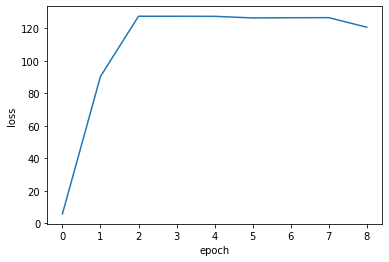

In [52]:
plt.plot(history.history['loss'][1:])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [51]:
uv = np.random.random((3,5))
t = uv /np.sqrt(np.sum(np.square(uv), axis=-1, keepdims=True))
np.sum(t*t, axis=-1) 

array([1., 1., 1.])

In [63]:
def cosine_similarity(a,b):
  
  a = a/np.expand_dims(np.linalg.norm(a,axis=-1),axis=-1)
  b = b/np.expand_dims(np.linalg.norm(b,axis=-1),axis=-1)
  dot_prod = np.sum(a*b,axis=-1)
  

  return dot_prod

In [65]:
def predict(a,b, margin=0):
  
  a = tokenizer.texts_to_sequences(a)
  b = tokenizer.texts_to_sequences(b)
  max_length = np.max((len(a),len(b)))
  max_length = 2**int(np.ceil(np.log2(max_length)))

  predict_input1 = tf.keras.preprocessing.sequence.pad_sequences(a,maxlen=max_length,padding=pad,truncating=pad)
  predict_input2 = tf.keras.preprocessing.sequence.pad_sequences(b,maxlen=max_length,padding=pad,truncating=pad)
  vectors = saimese([predict_input1,predict_input2])
  similarity = cosine_similarity(vectors[0], vectors[1])
 # print(similarity.shape)
  if similarity > 0:
    return 1
  else: 
    return 0

In [66]:
predict("How are you?","How you doing?")
predict("What is your age?","How old are you?")
predict("what is your name?","what is your age?")

1

In [136]:

def evaluate(inp, threshold):
  inp = inp.dropna()
  y = inp["is_duplicate"].values
  x1 = inp["question1"].values
  x2 = inp["question2"].values

  max_length = 128
  x1 = tokenizer.texts_to_sequences(x1)
  x2 = tokenizer.texts_to_sequences(x2) 

  predict_input1 = tf.keras.preprocessing.sequence.pad_sequences(x1,maxlen=max_length,padding=pad,truncating=pad)
  predict_input2 = tf.keras.preprocessing.sequence.pad_sequences(x2,maxlen=max_length,padding=pad,truncating=pad)

  total = y.shape[0]
  correct = 0
  true_positive = 0
  true_negative = 0
  false_positive = 0
  false_negative = 0
  for i in tqdm.tqdm(range(total//256)):

    y_pred_vectors = saimese([predict_input1[i*256:(i+1)*256],predict_input2[i*256:(i+1)*256]])
    y_pred = cosine_similarity(y_pred_vectors[0:256],y_pred_vectors[256:])

    y_pred_actual = 1*(y_pred > threshold)
  
    for j in range(256):
      if y[j]==1 and y_pred_actual[j]==1:
        correct+=1
        true_positive +=1
      elif y[j]==1 and y_pred_actual[j]==0:
        false_negative +=1
      elif y[j]==0 and y_pred_actual[j]==0:
        correct+=1
        true_negative +=1
      elif y[j]==0 and y_pred_actual[j]==1:
        false_positive +=1

  print("\n\nAccuracy: {}".format(correct/ total))

  print("------------------------------------------")
  print("|\t\t\tPredicted Values |")
  print("|\t\t\tTrue \t False\t |")
  print("| Actual\tTrue \t{}\t{}\t |".format(true_positive, false_negative))
  print("| Values\tFalse \t{}\t{}\t |".format(false_positive, true_negative))
  print("------------------------------------------")



  return 



In [138]:
full_train_data=pd.read_csv("./data/train.csv")
evaluate(full_train_data, 0.7)

KeyboardInterrupt: ignored